In [9]:
import pickle
from exp_code import *
%matplotlib inline
with open("gliomas.data","rb") as f:
    data = pickle.load(f)
whole_datasets = []
for key in data:
    if type(data[key]) == Experiment:
        globals()[key] = data[key]
        whole_datasets.append(key)
print("%s were loaded. They are:" % len(whole_datasets) )
print(" ".join(whole_datasets))

25 were loaded. They are:
GSE19578 GSE84010 GSE83294 GSE50021 GSE34824 GSE36245 GSE26576 GSE21420 GSE43378 GSE61374 GSE43388 GSE43107 CGGA E-TABM-898 E-TABM-3892 GSE4290 GSE7696 GSE16011 GSE43113 GSE68848 GSE72951 TCGA_microarray TCGA_LGG TCGA_GBM_SEQ GSE30336


In [2]:
data.keys()

dict_keys(['GSE19578', 'GSE84010', 'GSE83294', 'GSE50021', 'GSE34824', 'GSE36245', 'GSE26576', 'GSE21420', 'GSE43378', 'GSE61374', 'GSE43388', 'GSE43107', 'CGGA', 'E-TABM-898', 'E-TABM-3892', 'GSE4290', 'GSE7696', 'GSE16011', 'GSE43113', 'GSE68848', 'GSE72951', 'TCGA_microarray', 'TCGA_LGG', 'TCGA_GBM_SEQ', 'GSE30336', 'coding', 'noncoding'])

In [3]:
names=globals()
dataset = "GSE74187"
names[dataset]=Experiment(dataset+'_exp.csv',dataset+'_clinic.csv','survival','DATA',grade_label='grade',event='event')
datasets = ["GSE43378","GSE74187","GSE61374","GSE43388","GSE43107","CGGA","E-TABM-898","E-TABM-3892","GSE4290","GSE7696","GSE16011","GSE43113","GSE68848","GSE72951","TCGA_microarray","TCGA_LGG","TCGA_GBM_SEQ","GSE30336"]


In [4]:
ls =[]
for i in CGGA.exp.T: 
    if CGGA.exp.T[i].median()==0:
        ls.append(i)
CGGA.exp=CGGA.exp[~CGGA.exp.index.isin(ls)]

In [5]:
genes = CGGA.exp.index
for dataset in datasets:
    genes = [i for i in genes if i in globals()[dataset].exp.index]
    print (dataset,len(genes))

GSE43378 15246
GSE74187 14639
GSE61374 14639
GSE43388 13741
GSE43107 13719
CGGA 13719
E-TABM-898 13365
E-TABM-3892 13114
GSE4290 13114
GSE7696 13114
GSE16011 13114
GSE43113 13114
GSE68848 13114
GSE72951 12916
TCGA_microarray 9414
TCGA_LGG 9400
TCGA_GBM_SEQ 9400
GSE30336 9348


In [6]:
n = 100
result_GSE68848 = output_top(GSE68848.exp_split('grade',[4,3]),genes=genes,n=n,sep=True)
result_GSE4290 = output_top(GSE4290.exp_split('grade',[4,3]),genes=genes,n=n,sep=True)
result_GSE16011 = output_top(GSE16011.exp_split('grade',[4,3]),genes=genes,n=n,sep=True)
result_CGGA = output_top(CGGA.exp_split('grade',[4,3]),genes=genes,n=n,sep=True)

In [7]:
ls = []
for i in [0,1]:
    ls.append([j for j in result_GSE68848[i].index if j in result_CGGA[i].index])
    print (len(result_GSE68848[i]),len(result_CGGA[i]),len(ls[i]))
up = ls[0]
down = ls[1]

G68848G4 = consis_pair_up_down(up,down,GSE68848.exp_split('grade',4))
G68848G3 = consis_pair_up_down(up,down,GSE68848.exp_split('grade',3))
CGGAG4 = consis_pair_up_down(up,down,CGGA.exp_split('grade',4))
CGGAG3 = consis_pair_up_down(up,down,CGGA.exp_split('grade',3))

100 100 23
100 100 38
10
20
30
10
20
30
10
20
30
10
20
30


In [8]:
a77 = [i[:2] for i in G68848G4]
a88 = [i[:2] for i in G68848G3]
a1 = [i[:2] for i in CGGAG4]
a2 = [i[:2] for i in CGGAG3]
r2 = [i for i in a77 if (i[1],i[0]) in a88]
r3 = [i for i in a1 if (i[1],i[0]) in a2]
GR = list(set(r2) & set(r3))

dataset= CGGA
dataset.Mask_exp(GR)
GSE68848.Mask_exp(GR)
keys=["pair"+str(i) for i in range(len(GR))]
#TCGA_SEQ.event='event'
cf = None
df = pandas.concat([GSE68848.mask_matrix[GSE68848.mask_matrix.grade>=3],CGGA.mask_matrix[CGGA.mask_matrix.grade>=3]])
for i in range(len(GR)):
    df["pair"+str(i)]=df[[GR[i]]]
survival_label=dataset.survival_label
grade = dataset.grade_label
cf = CoxPHFitter()
labels = [survival_label,'pair_sum']
labels = ['survival']
if dataset.event:labels.append(dataset.event)
print(labels)
ls = []
for i in keys:
    cf.fit(df[labels+[i]].dropna(),survival_label,dataset.event)
    ls.append(cf.summary)
cf.fit(df[labels+['grade']].dropna(),survival_label,dataset.event)
ls.append(cf.summary)
cox = pandas.concat(ls)

len(GR),len(consis)

['survival', 'event']


KeyboardInterrupt: 

In [ ]:
from munkres import Munkres,print_matrix
matrix = [[0 for i in range(len(up))] for j in range(len(down))]

for i in range(len(GR)):
    #print(cox.ix[i]["exp(coef)"])
    matrix[down.index(GR[i][1])][up.index(GR[i][0])]=-1/cox.ix[i]["exp(coef)"]

m = Munkres()
consis = []
indexes = m.compute(matrix)
#print_matrix(matrix, msg='Lowest cost through this matrix:')
total = 0
for row, column in indexes:
    value = matrix[row][column]
    total += value
    if value !=0:
        print ('(%s, %s) -> %f' % ( up[column], down[row], value))
        consis.append((str(up[column]), str(down[row])))
print ('total cost: %f' % total)


In [ ]:
import mygene
mg = mygene.MyGeneInfo()
symbols=[(k["_id"],k["symbol"]) for k in mg.getgenes(up+down,'symbol')]
symbol_dic = {}
for symbol in symbols:
    symbol_dic[symbol[0]]=symbol[1]
consis_symbol = [[symbol_dic[i[0]],symbol_dic[i[1]]] for i in consis]
consis_symbol

In [ ]:
for data in datasets:
    print (data)
    dataset = globals()[data]
    dataset.Mask_exp(consis)

In [ ]:
ls = []
datasetsub=datasets
for dataset in datasetsub:
    df = globals()[dataset].mask_matrix
    if 'IDH'  not in globals()[dataset].mask_matrix:
        globals()[dataset].mask_matrix['IDH']=np.nan
    if 'codel'  not in globals()[dataset].mask_matrix:
        globals()[dataset].mask_matrix['codel']=np.nan
    if 'TERT'  not in globals()[dataset].mask_matrix:
        globals()[dataset].mask_matrix['TERT']=np.nan
    kk = ["Age","Diag","Gender"]
    for i in kk:
        if i  not in globals()[dataset].mask_matrix:
            globals()[dataset].mask_matrix[i]=np.nan
    keys = ['pair_sum','grade','survival','IDH','codel','event',"Age","Diag","Gender","TERT"]

    if 'event' in df:
        data = df[df.grade.notnull()][df['event'].notnull()][df.survival.notnull()][keys]
    else:
        df['event']=1
        data = df[df.grade.notnull()][df.event.notnull()][df.survival.notnull()][keys]
      
    print(dataset)
    data['p']=data['pair_sum'].apply(lambda x:scipy.stats.binom_test(x,21, 1.0/2,'greater') if x>=10 else scipy.stats.binom_test(x,21, 1.0/2,'less'))
    data['dataset']=dataset
    data['grade']=data['grade'].astype(int)
    for i in range(len(consis)):
        data['pair'+str(i+1)] = globals()[dataset].mask_matrix[consis[i]]        
    ls.append(data)
result = pandas.concat(ls)
result.to_csv("result.csv")

113 177


E:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


(13.77534246, 20.6)

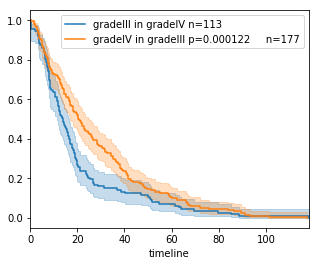

In [10]:
%matplotlib inline
pt = plt.figure(figsize=(5,4))
ds = ["GSE43378","GSE43107","GSE43388","GSE74187","CGGA","GSE7696","GSE16011","GSE68848","TCGA_LGG","TCGA_microarray","TCGA_GBM_SEQ","GSE30336"]
result = pandas.read_csv("result.csv",index_col=0)
result = result[result.dataset.isin(ds)]

T1=result['survival'][result.grade==3][result.pair_sum<=6]
E1=result['event'][result.grade==3][result.pair_sum<=6]
T2=result['survival'][result.grade==4][result.pair_sum>14]
E2=result['event'][result.grade==4][result.pair_sum>14]
#C2=clinic[event][clinic.index.isin(B)] if event else None
print (len(T1),len(T2))
p = logrank_test(T1,T2,E1,E2)
kmf = lifelines.KaplanMeierFitter()
#kmf.fit(T1,label='>%.2f %s %s %s' %(up,name,grade,num)).plot(ax=ax)
#kmf.fit(T2,label='<=%.2f p=%.6f in %d' %(down,p.p_value,len(cg))).plot(ax=ax)
kmf.fit(T1,label='%s n=%d' %('gradeIII in gradeIV',len(T1))).plot(ax=pt.add_subplot(111),show_censors=True)
kmf.fit(T2,label='%s p=%.6f     n=%d' % ('gradeIV in gradeIII',p.p_value,len(T2))).plot(ax=pt.add_subplot(111),show_censors=True)
T1.median(),T2.median()

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


8 16


E:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


15 29
30 86
9 43
18 97
45 124
47 357
5 104


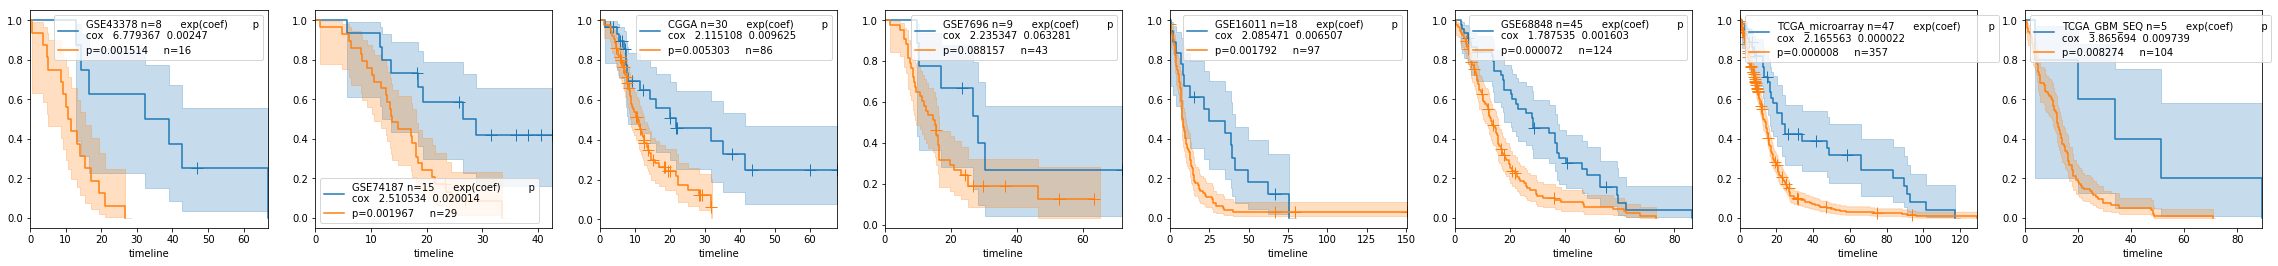

In [110]:

G3 = result[result.grade==4]
k = len(G3.dataset.unique())
pt = plt.figure(figsize=(5*k,4))
i=0
for dataset in G3.dataset.unique():
    i+=1
    data = G3[G3.dataset==dataset]
    survival = "survival"
    event = "event"
    A=G3[G3.pair_sum>14][G3.dataset==dataset]
    B=G3[G3.pair_sum<=6][G3.dataset==dataset]
    p = logrank_test(A[survival],B[survival],A[event] ,B[event])
    kmf = lifelines.KaplanMeierFitter()
    cf = CoxPHFitter()
    labels = ['survival','event']
    data['cox']=data.pair_sum.apply(lambda x: 0 if x>14 else 1)
    cf.fit(data[labels+['cox']],'survival','event')
    print(len(A),len(B))
    if len(A):
        kmf.fit(A[survival],A[event],label='%s n=%d %s' %(dataset,len(A),cf.summary[['exp(coef)','p']])).plot(ax=pt.add_subplot(1,k,i),show_censors=True)
    else:
        kmf.fit([1],label='%s  n=%d' %(dataset,len(A))).plot(ax=pt.add_subplot(1,k,i),show_censors=True)
    if len(B):
        kmf.fit(B[survival],B[event],label='p=%.6f     n=%d' % (p.p_value,len(B))).plot(ax=pt.add_subplot(1,k,i),show_censors=True)
    else:
        kmf.fit([1],None,label='p=%.6f     n=%d' % (p.p_value,len(B))).plot(ax=pt.add_subplot(1,k,i),show_censors=True)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


13 22


E:\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


22 24
12 41
20 50
12 51
27 174
7 19


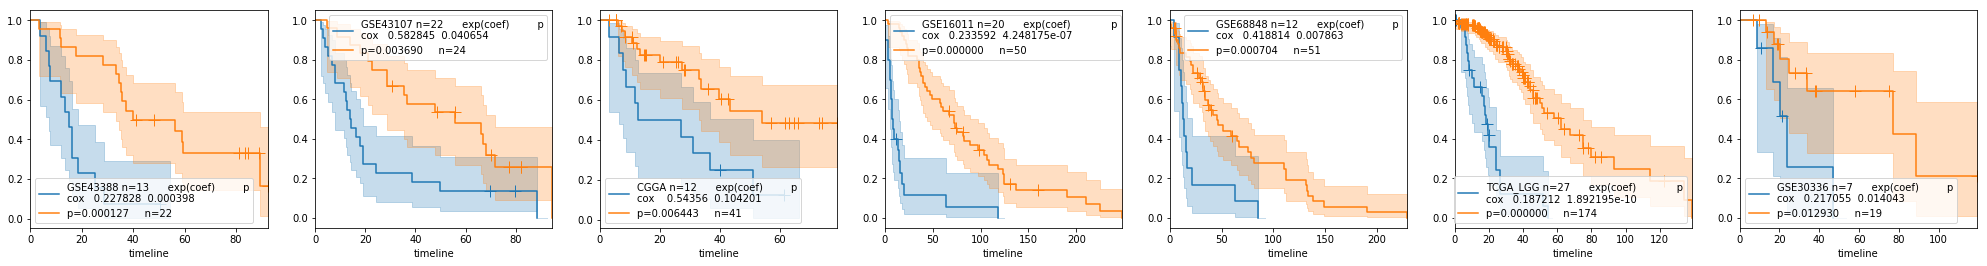

In [109]:

G3 = result[result.grade==3]
k = len(G3.dataset.unique())
pt = plt.figure(figsize=(5*k,4))
i=0
for dataset in G3.dataset.unique():
    i+=1
    data = G3[G3.dataset==dataset]
    survival = "survival"
    event = "event"
    A=G3[G3.pair_sum<=6][G3.dataset==dataset]
    B=G3[G3.pair_sum>14][G3.dataset==dataset]
    p = logrank_test(A[survival],B[survival],A[event] ,B[event])
    kmf = lifelines.KaplanMeierFitter()
    cf = CoxPHFitter()
    labels = ['survival','event']
    data['cox']=data.pair_sum.apply(lambda x: 0 if x<=6 else 1)
    if data["cox"].sum()==len(data["cox"]):
        continue
    cf.fit(data[labels+['cox']],'survival','event')
    print(len(A),len(B))
    if len(A):
        kmf.fit(A[survival],A[event],label='%s n=%d %s' %(dataset,len(A),cf.summary[['exp(coef)','p']])).plot(ax=pt.add_subplot(1,k,i),show_censors=True)
    else:
        kmf.fit([1],label='%s  n=%d' %(dataset,len(A))).plot(ax=pt.add_subplot(1,k,i),show_censors=True)
    if len(B):
        kmf.fit(B[survival],B[event],label='p=%.6f     n=%d' % (p.p_value,len(B))).plot(ax=pt.add_subplot(1,k,i),show_censors=True)
    else:
        kmf.fit([1],None,label='p=%.6f     n=%d' % (p.p_value,len(B))).plot(ax=pt.add_subplot(1,k,i),show_censors=True)

In [101]:
result[result.dataset=="GSE43378"][result.grade==3].pair_sum

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


GSM1061664    15.0
GSM1061666     8.0
GSM1061670    20.0
GSM1061671    15.0
GSM1061677    14.0
GSM1061689    18.0
GSM1061690    20.0
GSM1061697    20.0
GSM1061700    13.0
GSM1061701    19.0
GSM1061704    17.0
GSM1061706    19.0
GSM1061707    18.0
Name: pair_sum, dtype: float64

In [103]:
dataset

'GSE43378'